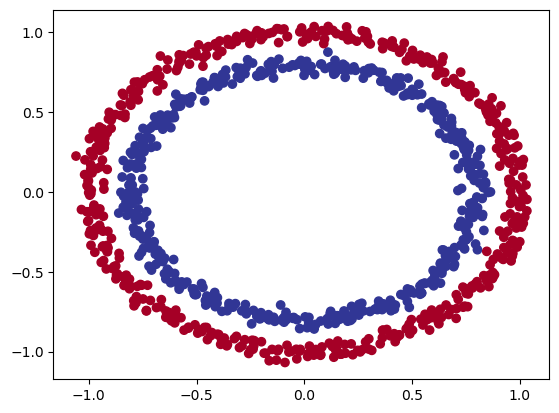

In [7]:
#Recreating non-linear data 
import matplotlib. pyplot as plt
from sklearn.datasets import make_circles



n_samples=1000
X,y = make_circles(n_samples,noise=0.03,
                   random_state=42)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [8]:
#Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

#Split into train and test sets

X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.2,
                                               random_state=42)

X_train[:5],y_train[:5]

cuda


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Building a model with Non-linearity

-> non straight lines

In [9]:
from torch import nn 

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1=nn.Linear(in_features=2,out_features=10)
        self.layer_2=nn.Linear(in_features=10,out_features=10)
        self.layer_3=nn.Linear(in_features=10,out_features=1)
        self.relu=nn.ReLU() #nonlinear activation function

    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3=CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [10]:
loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_3.parameters(),lr=0.1)

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc


In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):

    model_3.train()

    y_logits=model_3(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))

    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #Testing

    model_3.eval()
    with torch.inference_mode():
        test_logits=model_3(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))

        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)

    if epoch %100==0:
        print(f"Epoch: {epoch} | Loss:{loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} , Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss:0.69325, Acc: 50.00% | Test loss: 0.69524 , Test acc: 50.00%
Epoch: 100 | Loss:0.68919, Acc: 53.50% | Test loss: 0.69279 , Test acc: 47.00%
Epoch: 200 | Loss:0.68665, Acc: 53.37% | Test loss: 0.69220 , Test acc: 49.00%
Epoch: 300 | Loss:0.68394, Acc: 54.87% | Test loss: 0.69121 , Test acc: 49.00%
Epoch: 400 | Loss:0.68061, Acc: 55.38% | Test loss: 0.68921 , Test acc: 49.50%
Epoch: 500 | Loss:0.67604, Acc: 56.88% | Test loss: 0.68580 , Test acc: 50.50%
Epoch: 600 | Loss:0.66902, Acc: 65.75% | Test loss: 0.67972 , Test acc: 61.00%
Epoch: 700 | Loss:0.65735, Acc: 74.88% | Test loss: 0.66946 , Test acc: 68.50%
Epoch: 800 | Loss:0.63679, Acc: 83.75% | Test loss: 0.65182 , Test acc: 79.00%
Epoch: 900 | Loss:0.59973, Acc: 91.12% | Test loss: 0.62051 , Test acc: 87.00%


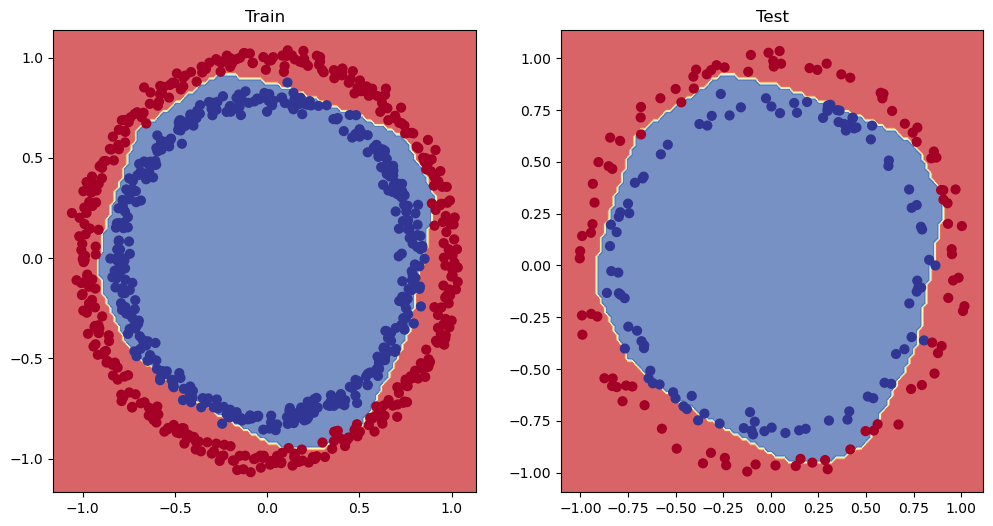

In [12]:
from helper_functions import plot_predictions,plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)